BoutInf (nBoutsx18):
- Columns 1 and 2: the start and end of the bout data in the continuous data variables
- Column 3: Number indicating the stimulus being shown during that bout
- Column 4: Original frame start number (allows actual timing of bout to be known, given 700 Hz frame rate)
- Columns 5:7 Pre-bout x, y position and theta in pixels and radians (???)
- Column 8: Eye Convergence during bout (2: converged; 1: not converged)
- Column 9: Change in eye convergence angle (degrees) during bout
- Column 10: Assigned eye convergence category (1=converge during  bout; 2=not converged ;  3=converged; 4=diverge during bout)
- Column 11: Bout category assigned using the scheme in Marques et al. 2018 (1=SCS; 2=LCS; 3=BS; 4=O-bend; 5=J-turn; 6=SLC; 7=S1; 8=RT; 9=S2; 10=LLC; 11=AS; 12=SAT; 13=HAT)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, ensure_dir, ZEBRAFISH_DIR
import urllib.request
ZEBRAFISH_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/data/raw/ZEBRAFISH_Data_Dir')

In [3]:
from tqdm.autonotebook import tqdm
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
mat_files = list(ZEBRAFISH_DIR.glob('**/*.mat'))

In [5]:
len(mat_files)

650

In [6]:
mat_files[0]

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/data/raw/ZEBRAFISH_Data_Dir/Phototaxis/Phototaxis4/Phototaxis400004.mat')

In [7]:
bout_df = pd.DataFrame(columns = ['mat_loc', 'bouts', 'bout_lens'])
for mfi, mat_file in enumerate(tqdm(mat_files)):
    ds = scipy.io.loadmat(mat_file.as_posix())
    BoutInf = ds['boutStructure'][0][0][0]
    bout_category = BoutInf[:,-1].astype('int')
    bout_df.loc[len(bout_df)] = [mat_file.as_posix(), bout_category, len(bout_category)]

In [8]:
bout_df[:3]

,mat_loc,bouts,bout_lens
0,/mnt/cube/tsainbur/Projects/github_repos/child...,"[12, 8, 9, 8, 7, 7, 8, 8, 13, 7, 8, 8, 8, 8, 8...",1808
1,/mnt/cube/tsainbur/Projects/github_repos/child...,"[13, 7, 12, 7, 9, 9, 9, 8, 13, 7, 7, 7, 8, 7, ...",1528
2,/mnt/cube/tsainbur/Projects/github_repos/child...,"[7, 8, 12, 8, 9, 7, 9, 9, 7, 9, 7, 7, 5, 8, 7,...",2296


In [9]:
len(bout_df)

650

In [10]:
np.unique(np.concatenate(bout_df.bouts.values))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [11]:
np.sum(bout_df.bout_lens)

1869270

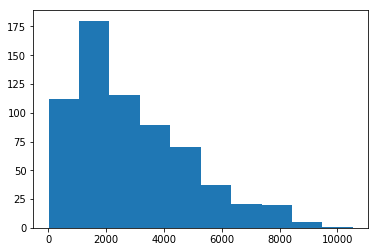

In [12]:
plt.hist(bout_df.bout_lens.values.astype('int'));

### Mutual information

In [13]:
bouts = [list(i.astype('int'))  for i in bout_df.bouts.values]

In [14]:
def remove_repeats(sequence):
    return [element for i, element in enumerate(sequence[1:]) if sequence[i] != element]

In [15]:
bouts_indv = [["{}_{}".format(bi, element) for element in bout] for bi, bout in enumerate(tqdm(bouts))]

In [16]:
bouts_indv_rr = [remove_repeats(i) for i in bouts_indv]

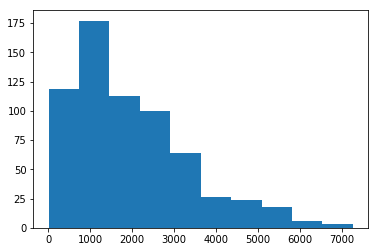

In [17]:
plt.hist([len(i) for i in bouts_indv_rr]);

In [18]:
from childes_mi.information_theory import mutual_information as mi

In [19]:
distances = np.arange(1,1001)

### longest sequence

In [20]:
from pathlib2 import Path

In [21]:
bout_df['condition'] = [Path(i).parent.parent.stem for i in bout_df.mat_loc.values]

In [22]:
np.unique(bout_df.condition.values)

array(['3minLightDark', 'AcousticLightDark', 'DarkLightTransitions',
       'LoomingDifferentDirections', 'LoomingDifferentSpeeds', 'OMRSpeed',
       'OMRSpontaneousTu', 'OMRSpontaneousTu2', 'OMRTurns', 'Phototaxis',
       'PreyCaptureExpTu', 'PreyCaptureExpTu2', 'PreyCaptureNaive',
       'PreyCaptureNaiveTu', 'PreyCaptureNaiveTu2',
       'PreyCaptureSmallRotTuNaive', 'PreyCaptureSmallRotTuNaive2',
       'PreyCaptureSmallRotTuWithRot', 'SpontaneousMultiFishDark',
       'SpontaneousMultiFishLightA', 'SpontaneousWEyeTracking'],
      dtype=object)

In [23]:
bout_df[:3]

,mat_loc,bouts,bout_lens,condition
0,/mnt/cube/tsainbur/Projects/github_repos/child...,"[12, 8, 9, 8, 7, 7, 8, 8, 13, 7, 8, 8, 8, 8, 8...",1808,Phototaxis
1,/mnt/cube/tsainbur/Projects/github_repos/child...,"[13, 7, 12, 7, 9, 9, 9, 8, 13, 7, 7, 7, 8, 7, ...",1528,Phototaxis
2,/mnt/cube/tsainbur/Projects/github_repos/child...,"[7, 8, 12, 8, 9, 7, 9, 9, 7, 9, 7, 7, 5, 8, 7,...",2296,Phototaxis


In [24]:
nex = 5
MI_DFs = []
for cond in tqdm(np.unique(bout_df.condition.values)):
    cond_df = bout_df[bout_df.condition.values == cond]
    for idx, row in tqdm(cond_df.sort_values(by=['bout_lens'], ascending=False)[:nex].iterrows(), total=nex):
        seq = row.bouts
        (MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
            [remove_repeats(seq)], distances=distances, n_jobs=-1, estimate=True
        )

        MI_DF1 = pd.DataFrame(
            [[MI, MI_var, shuff_MI, shuff_MI_var, distances, row.condition, row.bout_lens]],
            columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances", "condition", "bout_len"],
        )
        MI_DFs.append(MI_DF1)
MI_DF_longest = pd.concat(MI_DFs)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.1s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.8s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.9s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.7s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.4s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:    3.0s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.3s finished


In [26]:
MI_DF_longest[:5]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,condition,bout_len
0,"[3.6160812103314255, 3.416079422364989, 3.3585...","[0.08675540320246419, 0.08494038479067434, 0.0...","[3.30933957261308, 3.3053806950690134, 3.30555...","[0.08573309140832686, 0.0851714340072155, 0.08...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3minLightDark,2430
0,"[3.567153544450651, 3.367099427547494, 3.31127...","[0.07413824353274776, 0.07357521034624526, 0.0...","[3.2485276943822496, 3.2504032668457388, 3.237...","[0.07446854441740954, 0.07410522791187488, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3minLightDark,2219
0,"[3.5607804498409665, 3.350896857876787, 3.2808...","[0.08092161608016024, 0.08078144966519044, 0.0...","[3.2166231094602953, 3.2083505249868027, 3.219...","[0.0805620291739147, 0.08162669462228765, 0.08...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3minLightDark,2202
0,"[3.6824280332687973, 3.4583121506422803, 3.401...","[0.07077427734147282, 0.06853375424101843, 0.0...","[3.254500767077449, 3.2491152648627075, 3.2494...","[0.06862015253563539, 0.06836788414027643, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3minLightDark,2196
0,"[3.5818399867844155, 3.3592442108083045, 3.284...","[0.08629783904030457, 0.08559458410526402, 0.0...","[3.2287839079883387, 3.2320953866211113, 3.233...","[0.08462182936439652, 0.08545338824097157, 0.0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3minLightDark,2141


In [27]:
MI_DF_longest.to_pickle(DATA_DIR / "mi" / "zebra_fish_longest.pickle")

In [28]:
MI_DF_longest.condition.unique()

array(['3minLightDark', 'AcousticLightDark', 'DarkLightTransitions',
       'LoomingDifferentDirections', 'LoomingDifferentSpeeds', 'OMRSpeed',
       'OMRSpontaneousTu', 'OMRSpontaneousTu2', 'OMRTurns', 'Phototaxis',
       'PreyCaptureExpTu', 'PreyCaptureExpTu2', 'PreyCaptureNaive',
       'PreyCaptureNaiveTu', 'PreyCaptureNaiveTu2',
       'PreyCaptureSmallRotTuNaive', 'PreyCaptureSmallRotTuNaive2',
       'PreyCaptureSmallRotTuWithRot', 'SpontaneousMultiFishDark',
       'SpontaneousMultiFishLightA', 'SpontaneousWEyeTracking'],
      dtype=object)

In [29]:
len(MI_DF_longest)

105

In [31]:
105/8

13.125

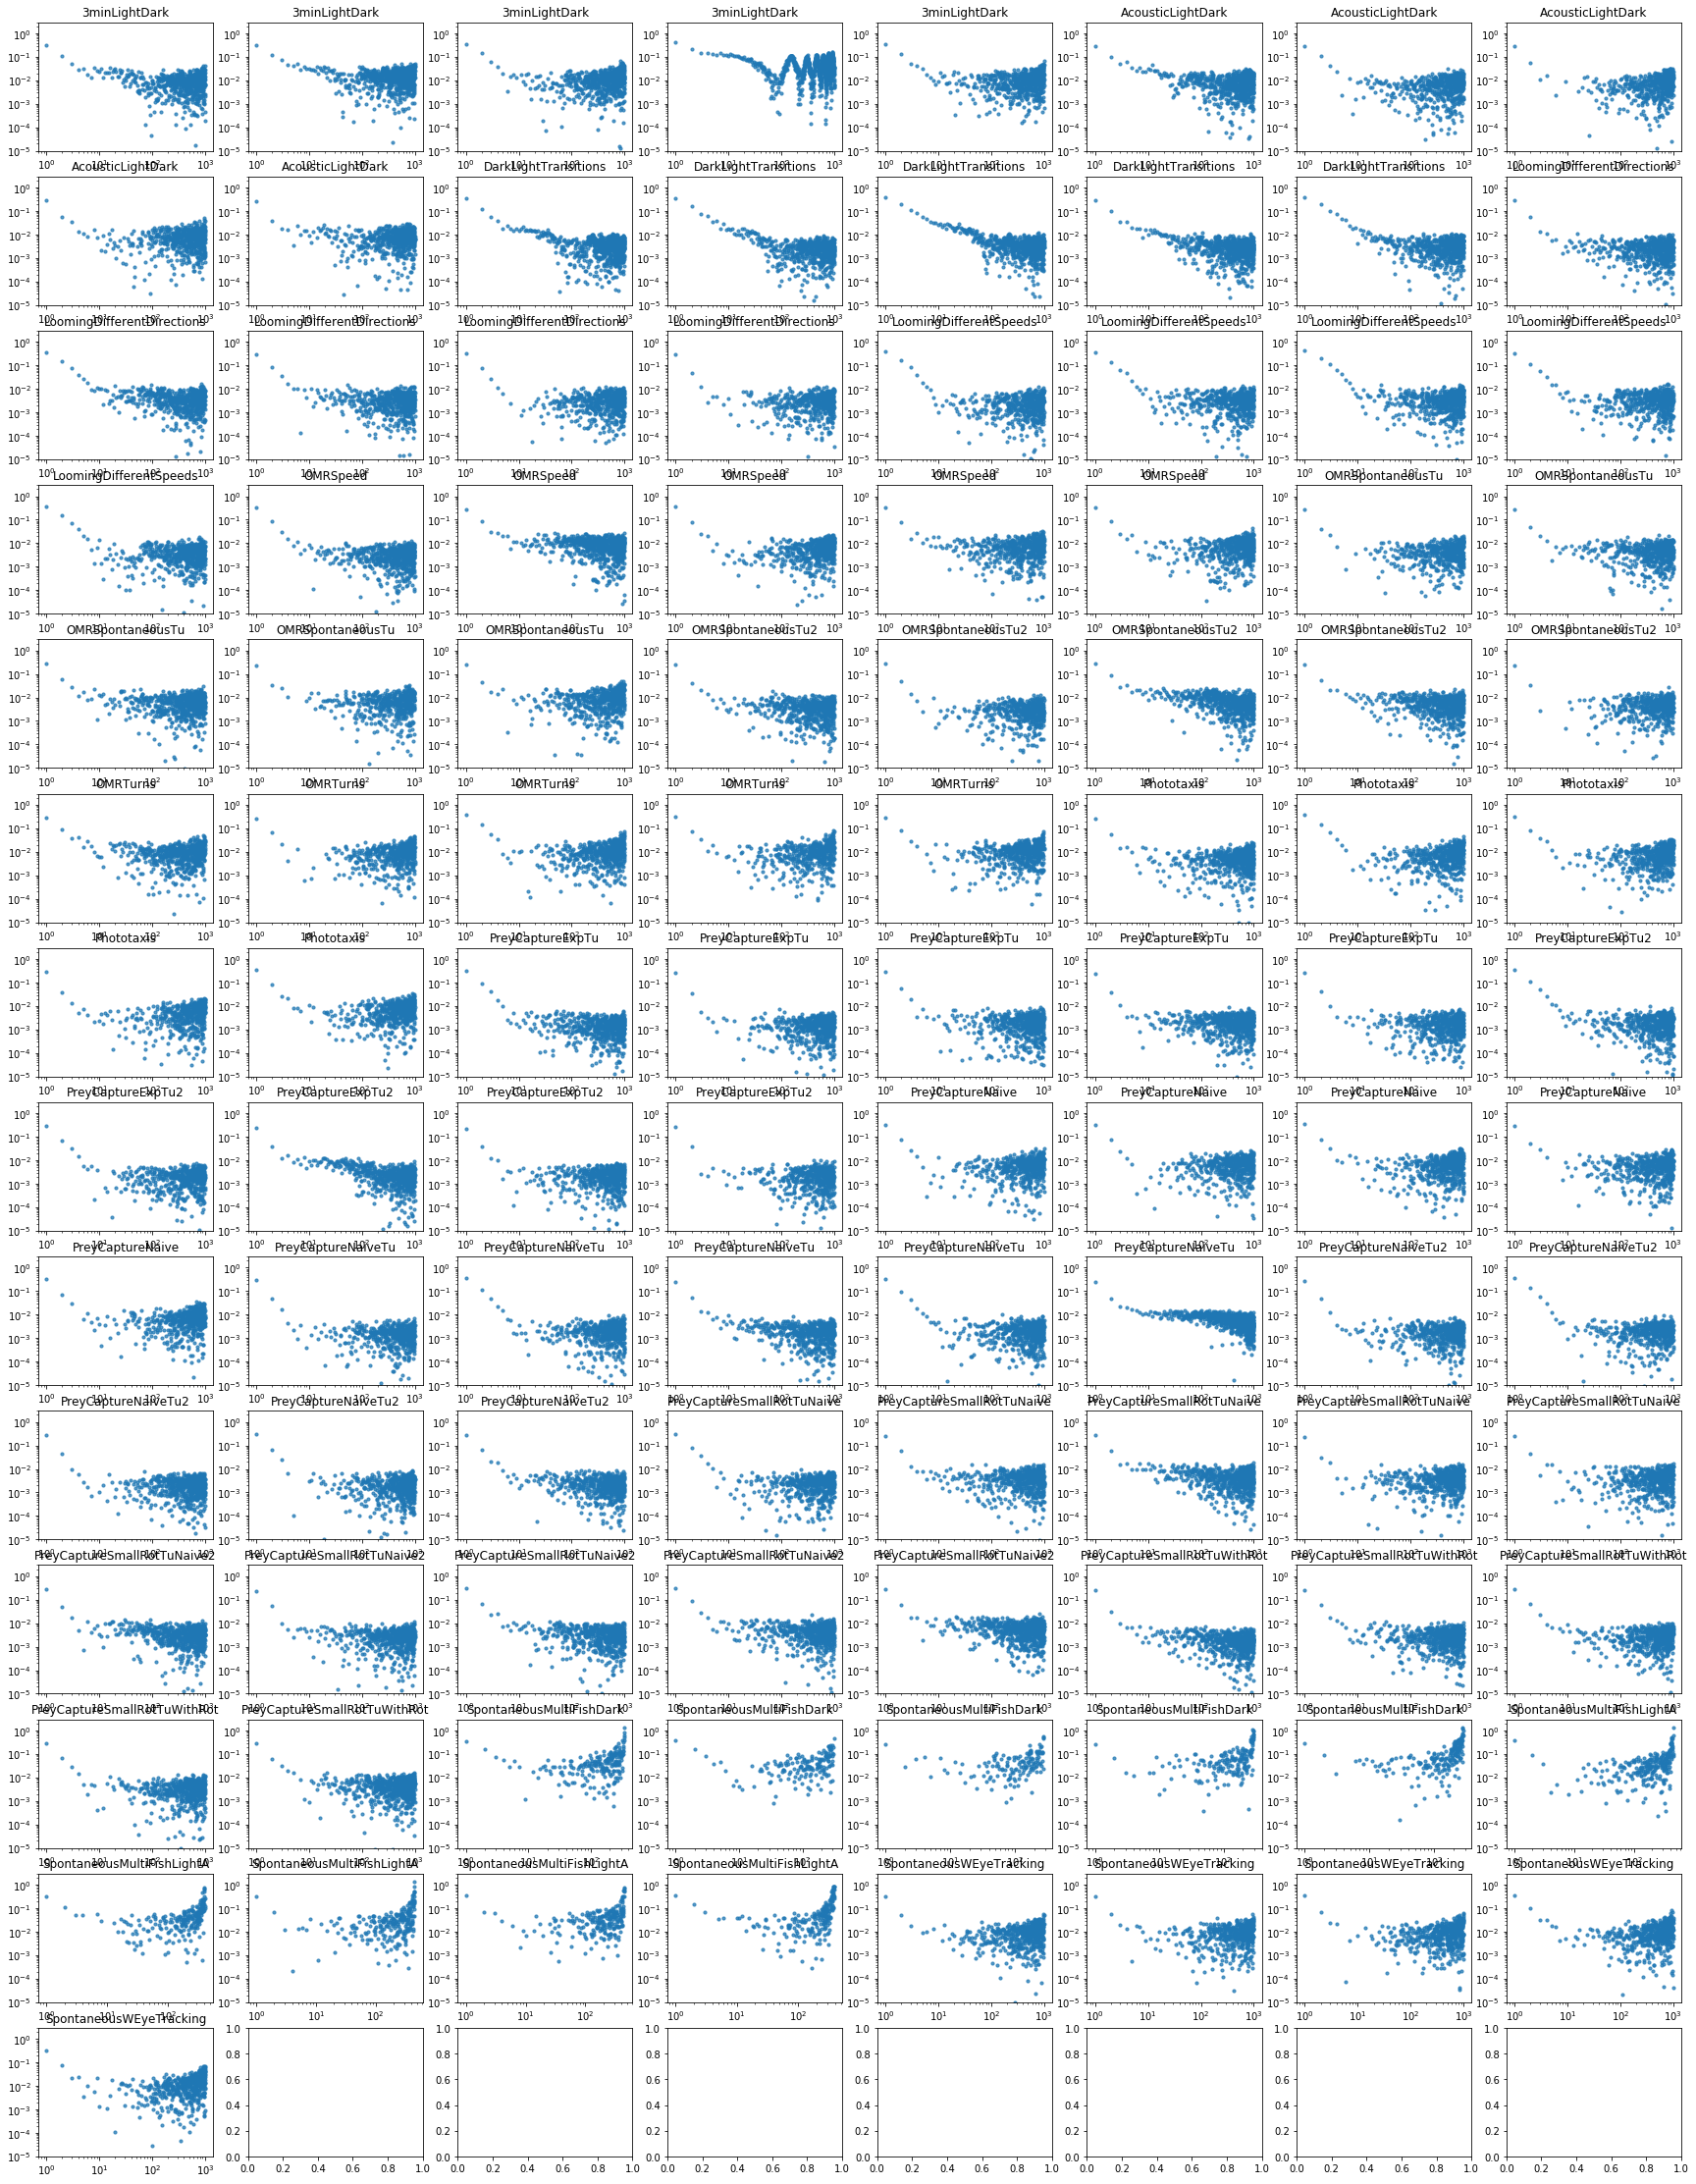

In [32]:
fig, axs = plt.subplots(ncols = 8, nrows=14, figsize = (30,40))
for ri, (idx, row) in tqdm(enumerate(MI_DF_longest.iterrows())):
    ax = axs.flatten()[ri]
    MI = row.MI-row.shuff_MI
    MI_var = row.MI_var
    ax.set_title(row.condition)
    ax.scatter(distances, MI, alpha=0.75, s=10)
    #ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
    ax.set_ylim([1e-5, 3])
    ax.set_yscale('log')
    ax.set_xscale('log')